In [1]:
##main - extract from DB
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import pyodbc
import json
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from jsonmerge import merge
from datetime import datetime
from num2words import num2words
import numpy as np
import pickle

server_p = 'sqlehqraiqhpoc.database.windows.net'

database = 'TempData'
driver = '{ODBC Driver 17 for SQL Server}'
#table_name='ESI_LOG'
owner ='dbo'

conn = pyodbc.connect('DRIVER='+driver+';SERVER='+server_p+
                      ';PORT=1433;DATABASE='+database+';Authentication=ActiveDirectoryInteractive;UID=a-weeck@health.qld.gov.au')         
sql_0 = pd.read_sql_query('''SELECT Referral_Category, icd10list FROM vw_referral''',conn)
df = pd.DataFrame(sql_0, columns=['Referral_Category','icd10list'])

####################
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
X = df['icd10list'].values
y = df['Referral_Category'].values
y = [num2words(i) for i in y]
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.1, random_state=88)

vectorize_x = CountVectorizer()
vectorize_x.fit(X)
X_train = vectorize_x.transform(X_train1)
X_test  = vectorize_x.transform(X_test1)

vectorize_y = CountVectorizer() 
vectorize_y.fit(y)
y_train = vectorize_y.transform(y_train1)
y_test  = vectorize_y.transform(y_test1)

pickle.dump(vectorize_x, open("vectorx.pkl", "wb"))
pickle.dump(vectorize_y, open("vectory.pkl", "wb"))

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3206)              5142424   
_________________________________________________________________
dense_2 (Dense)              (None, 1603)              5140821   
_________________________________________________________________
dense_3 (Dense)              (None, 500)               802000    
_________________________________________________________________
dense_4 (Dense)              (None, 50)                25050     
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 153       
Total params: 11,110,448
Trainable params: 11,110,448
Non-trainable params: 0
_________________________________________________________________
Train on 2395 samples, validate on 267 samples
Epoch 1/50
2395/2395 [==============================] - 2s 73

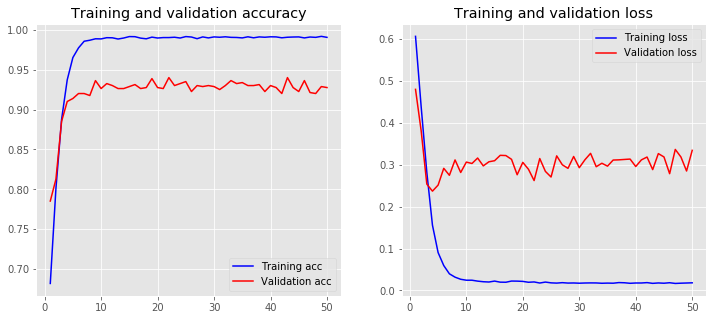

In [2]:
##neural network
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import matplotlib.pyplot as plt
import pickle
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

input_dim = X_train.shape[1]  # Number of features
model = Sequential()
model.add(Dense(input_dim*2, input_dim=input_dim, activation='relu'))
model.add(Dense(input_dim, input_dim=input_dim, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(500, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dense( 3, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train, epochs=50, verbose=1, validation_data=(X_test, y_test), batch_size=500)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)
pickle.dump(model, open('referralai.pkl', 'wb'))

In [3]:
#test run on prediction using one example
a='T14.90, R52, B20, E11.9, T14.8, Z86.73, K52.9, T63.301'
a=[a]
vectorize_x = pickle.load(open('vectorx.pkl', 'rb'))
vectorize_y = pickle.load(open('vectory.pkl', 'rb'))
vect_feature = vectorize_x.transform(a)
model = pickle.load(open('referralai.pkl', 'rb'))
pred = model.predict(vect_feature)
result=vectorize_y.inverse_transform(np.round(pred))
print(result[0][0])

one


In [4]:
#predict the classes
import numpy as np
#print(X_test.shape)
y_pred=model.predict(X_test)

#decode back to letters and then numbers
y_test1=vectorize_y.inverse_transform(y_test)
y_pred1=vectorize_y.inverse_transform(np.round(y_pred))

def text2num(i):
    if i=='one':
       j=1
    elif i=='two':
       j=2
    elif i=='three':
       j=3
    else:
       j=0
    return j

y_test2=[]
y_pred2=[]

for i in y_test1:
    y_test2.append(text2num(i))   
y_test2 = np.array(y_test2)

for i in y_pred1:
    y_pred2.append(text2num(i))   
y_pred2 = np.array(y_pred2)


c:\users\weeck\appdata\local\continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  # This is added back by InteractiveShellApp.init_path()
c:\users\weeck\appdata\local\continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  del sys.path[0]
c:\users\weeck\appdata\local\continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  from ipykernel import kernelapp as app


Predicted  0   1   2   3  All
Actual                       
1          0  76   6   2   84
2          0   7  72   6   85
3          1   4   2  91   98
All        1  87  80  99  267


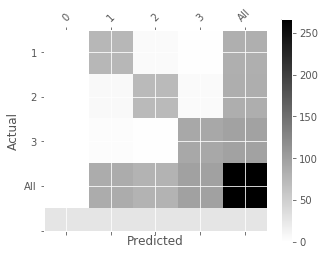

In [107]:
##Confusion matrix
import numpy as np

from sklearn.metrics import confusion_matrix
df_confusion = pd.crosstab(y_test2, y_pred2, rownames=['Actual'], colnames=['Predicted'], margins=True)
print (df_confusion)
import matplotlib.pyplot as plt
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

plot_confusion_matrix(df_confusion)

In [ ]:
#######################################################
######serving up as a web service
#######################################################
#!flask/bin/python
import os
from flask import request
from flask import Flask, request, jsonify, render_template
import pandas as pd
from sklearn import linear_model
from sklearn import datasets
import pickle
import numpy as np

#T14.90, R52, B20, E11.9, T14.8, Z86.73, K52.9, T63.301

app = Flask(__name__)
vectorize_x = pickle.load(open('vectorx.pkl', 'rb'))
vectorize_y = pickle.load(open('vectory.pkl', 'rb'))
model = pickle.load(open('referralai.pkl', 'rb'))

@app.route('/')
def home():
    return render_template('home.html')


@app.route('/predict',methods=['POST'])
def predict():
    feature = [str(x)for x in request.form.values()]
    feature = vectorize_x.transform(feature)
    pred = model.predict(feature)
    result=vectorize_y.inverse_transform(np.round(pred))
    result=str(result[0][0])
    return render_template('home.html', prediction_text='Triaged urgency for referral = {}'.format(result))


@app.route('/predict_api', methods=['POST'])
def predict_api():
    data = request.form.values()
#     vect_feature = vectorize_x.transform(data.values())
#     pred = model.predict(vect_feature)
#     result=vectorize_y.inverse_transform(np.round(pred))
#     return str(result[0][0])
    return str(data)

if __name__ == '__main__':
    app.run(port=4444,host='127.0.0.1',threaded=False)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:4444/ (Press CTRL+C to quit)
127.0.0.1 - - [10/Feb/2021 15:13:30] "GET /predict_api HTTP/1.1" 405 -
127.0.0.1 - - [10/Feb/2021 15:13:40] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 15:13:40] "GET /static/css/style.css HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 15:13:40] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [10/Feb/2021 15:20:53] "GET /predict_api['referral_content':'I63.9,S02.2,Z18.12,W19,R04.0,M51.26,I44.1'] HTTP/1.1" 404 -
127.0.0.1 - - [10/Feb/2021 15:20:54] "GET /predict_api/?json={%27referral_content%27:%27I63.9,S02.2,Z18.12,W19,R04.0,M51.26,I44.1%27} HTTP/1.1" 404 -
127.0.0.1 - - [10/Feb/2021 15:20:55] "GET /predict_api/?%27referral_content%27:%27I63.9,S02.2,Z18.12,W19,R04.0,M51.26,I44.1%27 HTTP/1.1" 404 -
127.0.0.1 - - [10/Feb/2021 15:20:56] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 15:20:56] "GET /static/css/style.css HTTP/1.1" 200 -
127.0.0.1 - - [10/Feb/2021 15:21:29] "GET /predict_api HTTP/1.1" 405 -


In [178]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

aa=[]
for i in X:
    #ii='\''+i.replace(', ','\',\'')+'\''
    aa.append(list(i.split(',')))

dataset=aa
te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = pd.DataFrame(te_ary, columns=te.columns_)
df
apriori(df, min_support=0.008, use_colnames=True)

,support,itemsets
0,0.009767,( B19_20)
1,0.019910,( B20)
2,0.011645,( B34_9)
3,0.017280,( B96_89)
4,0.061232,( B99_9)
...,...,...
1021,0.010894,"( T63_301, E11_9, K52_9, B20, T14_90, T14..."
1022,0.010894,"( T63_301, E11_9, B20, T14_90, T14_8, R52..."
1023,0.010894,"( T63_301, K52_9, B20, T14_90, T14_8, R52..."
1024,0.012021,"( T63_301, E11_9, K52_9, T14_90, T14_8, R..."


In [ ]:
!pip show tensorflow